In [1]:
import numpy as np
import rp
import torch
import torch.nn as nn
import source.stable_diffusion as sd
from easydict import EasyDict
from source.learnable_textures import LearnableImageFourier
from source.stable_diffusion_labels import NegativeLabel
from itertools import chain
import time

Current Process: 3584830 python


In [2]:
#ONLY GOOD PROMPTS HERE
example_prompts = rp.load_yaml_file('source/example_prompts.yaml')
print('Available example prompts:', ', '.join(example_prompts))

#These prompts are all strings - you can replace them with whatever you want! By default it lets you choose from example prompts
prompt_a, prompt_b, prompt_c, prompt_d, prompt_z = rp.gather(example_prompts, 'miku froggo lipstick kitten_in_box darth_vader'.split())
#Prompts a,b,c,d are the normal looking images
#Prompt z is the hidden image you get when you overlay them all on top of each other

negative_prompt = ''

print()
print('Negative prompt:',repr(negative_prompt))
print()
print('Chosen prompts:')
print('    prompt_a =', repr(prompt_a))
print('    prompt_b =', repr(prompt_b))
print('    prompt_c =', repr(prompt_c))
print('    prompt_d =', repr(prompt_d))
print('    prompt_z =', repr(prompt_z))

Available example prompts: kitten_in_box, botw_landscape, magic_emma_watson, yorkshire_terrier_santa, norwegian_winter_girl, magic_forest_temple, sailing_ship, bioshock_lighthouse, two_bunnys_hugging, thomas_tank_military, wolf_on_rock, victorial_dress, lolita_dress_magical_elf, pencil_giraffe_head, pencil_penguin, pencil_violin, pencil_orca_whale, pencil_cow, pencil_walrus, pencil_cat_head, pencil_dog_head, ape_with_gun, human_skeleton, gold_coins, golf_ball_in_forest, bear_in_forest, elephant_in_circus, mickey_mouse, mushroom, mario, burger, darth_vader, gandalf, fantasy_city, green_elf_girl, pikachu, spring, fall, winter, summer, miku, pyramids, dinosaur, lipstick, picard, bull_wing, froggo, assasin_creed, moon, minecraft_zombie, pistol, disco_ball, volcano, porche, hawaii_beach, walter_white, dalek, tardis, tennant, weeping_angel

Negative prompt: ''

Chosen prompts:
    prompt_a = 'Hatsune miku, gorgeous, amazing, elegant, intricate, highly detailed, digital painting, artstation, 

# New Section

In [3]:
if 's' not in dir():
    model_name='CompVis/stable-diffusion-v1-4'      # 512 Base model 1.4
    # model_name='runwayml/stable-diffusion-v1-5'     # 512 Base model 1.5
    model_name='stabilityai/stable-diffusion-2'     # 768 Base model 2.0
    # model_name='stabilityai/stable-diffusion-2-1'   # 768 Base model 2.1
    # model_name='sd-dreambooth-library/fashion'      # 512 Fashion stuff?
    # model_name='nitrosocke/mo-di-diffusion'         # 512 Dreambooth: Use 'modern disney style' in prompt. Pixar style.
    # model_name='nitrosocke/archer-diffusion'        # 512 Dreambooth: Use 'archer style' in prompt. Thick outline clean cartoon style.
    # model_name='nitrosocke/nitro-diffusion'         # 512 Dreambooth: Use 'arcane style', 'archer style' and/or 'modern disney style' in your prompt
    # model_name='Envvi/Inkpunk-Diffusion'            # 512 Dreambooth: Use 'nvinkpunk' in prompt. Looks kinda like borderlands, but more dramatic and artistic.
    # model_name='nitrosocke/classic-anim-diffusion'  # 512 Dreambooth: Use 'classic disney style' in prompt. Old timey disney style.
    # model_name='nitrosocke/Ghibli-Diffusion'        # 512 Dreambooth: Use 'ghibli style' in prompt. Studio Ghibli anime style.
    # model_name='hakurei/waifu-diffusion'            # 512 Fine Tuned: No special prompting needed
    # model_name='hakurei/artstation-diffusion'       # 512 Fine Tuned: No special prompting needed
    # model_name='prompthero/openjourney-v4'          # 512 Fine Tuned: No special prompting needed
    
    gpu=str(rp.select_torch_device())
    s=sd.StableDiffusion(gpu,model_name)
device=s.device;

                      ┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━━━━┓
                      ┃ GPU ID ┃       Name       ┃      Used      ┃   Free ┃  Total ┃ Temp ┃ Util ┃ Processes ┃
                      ┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━━━━┩
Selecting cuda:0 –––> │   0    │ NVIDIA RTX A5000 │ 311.6MB   1.3% │ 23.7GB │ 24.0GB │ 54°C │   0% │           │
                      │   1    │ NVIDIA RTX A5000 │ 311.6MB   1.3% │ 23.7GB │ 24.0GB │ 43°C │   0% │           │
                      │   2    │ NVIDIA RTX A5000 │ 311.6MB   1.3% │ 23.7GB │ 24.0GB │ 43°C │   0% │           │
                      │   3    │ NVIDIA RTX A5000 │ 311.6MB   1.3% │ 23.7GB │ 24.0GB │ 39°C │   0% │           │
                      └────────┴──────────────────┴────────────────┴────────┴────────┴──────┴──────┴───────────┘
[INFO] StableDiffusion: loading checkpoint 'stabilityai/stable-diffusion-2' ... please make sure

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

[INFO] StableDiffusion: loaded stable diffusion!


In [4]:
label_a = NegativeLabel(prompt_a + ' nvinkpunk',negative_prompt)
label_b = NegativeLabel(prompt_b + ' nvinkpunk',negative_prompt)
label_c = NegativeLabel(prompt_c + ' nvinkpunk',negative_prompt)
label_d = NegativeLabel(prompt_d + ' nvinkpunk',negative_prompt)
label_z = NegativeLabel(prompt_z + ' nvinkpunk',negative_prompt)

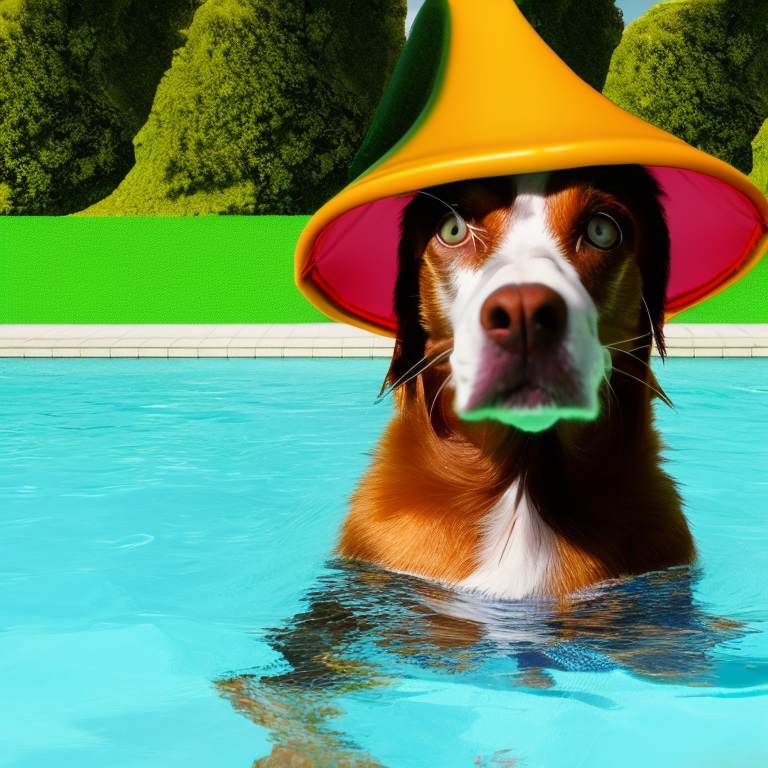

In [9]:
# s.height=s.width=256
# s.height=s.width=512
s.height=s.width=768
# s.height=s.width=1024
# s.height=s.width=2048

prompt='modern disney style Closeup face portrait of a black girl wearing crown of flowers, smooth soft skin, big dreamy eyes, beautiful intricate colored hair, symmetrical, anime wide eyes, soft lighting, detailed face, by makoto shinkai, stanley artgerm lau, wlop, rossdraws, concept art, digital painting, looking into camera'
prompt='archer style Closeup face portrait of a black girl wearing crown of flowers, smooth soft skin, big dreamy eyes, beautiful intricate colored hair, symmetrical, anime wide eyes, soft lighting, detailed face, by makoto shinkai, stanley artgerm lau, wlop, rossdraws, concept art, digital painting, looking into camera'
prompt='arcane style, a magical princess with golden hair'
prompt='arcane style, a magical princess with golden hair'
prompt='a swimming dog wearing a hat on a greenscreen'
# prompt='ghibli style anime girl'
label=NegativeLabel(prompt,'ugly unrealistic blurry')
label=NegativeLabel(prompt)
# image=label.get_sample_image(guidance_scale=16,num_steps=100)
image=label.get_sample_image(guidance_scale=10,num_steps=50)
# rp.rinsp(image)
rp.display_image(image)

In [6]:
s.pipe.unet.config

FrozenDict([('sample_size', 96),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 1024),
            ('